## 1. Import/Install Dependencies

In [7]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.utils import env_checker
from gymnasium.spaces import Box, Discrete
from mss import mss
import cv2
import pydirectinput
import torch
from torch import nn

# Check version of pytorch
torch.__version__

'2.4.1+cu124'

## 2. Construct Environment

In [12]:
class PacMan(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,50,80), dtype=np.uint8)
        self.action_space = Discrete(5)
        self.game_location = {'top':50, 'left':-2280, 'width':2000, 'height':1300}
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200}
        self.cap = mss()
        
    # Action method that is called to do something in the game
    def step(self, action):
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
            4: 'no_op'   # No operation (do nothing)
        }
        if action != 4:
            pydirectinput.press(action_map[action])
        
        # Get the next observation
        new_observation = self.get_observation()
        # Determine if the game is finished   
        done = self.get_done()
        
        if not done:
            reward += 10
        else:
            reward -= 30
            
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return new_observation, reward, done, False, info
    
    def get_observation(self):
        # Get screen capture of game
        raw_screen_cap = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Convert to Grayscale
        gray_cap = cv2.cvtColor(raw_screen_cap, cv2.COLOR_BGR2GRAY)
        # Resize capture
        resized = cv2.resize(gray_cap, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Method to Restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pydirectinput.click(x=-890, y=374) # select game window
        pydirectinput.press('f1') # Start state 1 save
        return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
        
    def get_done(self):
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv2.cvtColor(lives_cap, cv2.COLOR_BGR2GRAY)
        # Load pacman life icon template for comparison
        pacman_life_template = cv2.imread('pacman_life_icon.png', 0)
        # Perform template matching using computer vision
        result = cv2.matchTemplate(lives_gray, pacman_life_template, cv2.TM_CCORR_NORMED)
        threshold = 0.8
        locations = np.where(result >= threshold)
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives == 0, lives_cap

#### Demonstrate

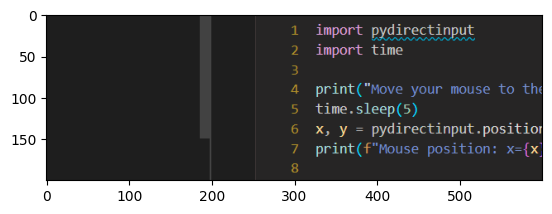

In [13]:
env = PacMan()
done, lives_cap= env.get_done()
plt.imshow(lives_cap)